Cell 1 — Setup & imports

In [ ]:
# Cell 1: Setup & imports
import os, time, random, math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# mixed precision
from torch.cuda.amp import autocast, GradScaler

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("PyTorch:", torch.__version__, "Torchvision:", torchvision.__version__)


Device: cuda
PyTorch: 2.8.0+cu126 Torchvision: 0.23.0+cu126


Cell 2 — Config (tune these once)

In [ ]:
# Cell 2: Configuration - change only these if needed
USE_DRIVE = False            # set True to save checkpoints to Google Drive
DRIVE_PATH = "/content/drive/MyDrive/cifar_transfer"

DATA_ROOT = "./data"

# Target mode: using transfer learning (recommended)
MODEL_NAME = "resnet50"      # resnet50 (ImageNet pretrained) - best balance
IMG_SIZE = 224               # resize CIFAR->224 for ImageNet backbone

# Runtime budget & hyperparams (tuned to fit ~<=5 hours on Colab T4)
TOTAL_EPOCHS = 25            # total fine-tune epochs (head+full)
HEAD_EPOCHS = 3              # epochs to train only final head first
BATCH_SIZE = 128             # try 128 on T4; reduce to 64 if OOM
EVAL_BATCH_SIZE = 256
NUM_WORKERS = 4

LR = 1e-3                    # base LR for fine-tuning full model
HEAD_LR = 1e-2               # higher LR for head-only stage
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

USE_MIXUP = False            # optional (True can improve generalization)
MIXUP_ALPHA = 0.2

SAVE_DIR = "./checkpoints_transfer"  # where to save models (or set USE_DRIVE True)
os.makedirs(SAVE_DIR, exist_ok=True)

print("IMG_SIZE", IMG_SIZE, "BATCH_SIZE", BATCH_SIZE, "TOTAL_EPOCHS", TOTAL_EPOCHS)


IMG_SIZE 224 BATCH_SIZE 128 TOTAL_EPOCHS 25


Cell 3 — (Optional) Mount Google Drive

In [ ]:
# Cell 3: Optional - mount Google Drive to persist checkpoints
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    SAVE_DIR = DRIVE_PATH
    os.makedirs(SAVE_DIR, exist_ok=True)
print("Checkpoints will be saved to:", SAVE_DIR)


Checkpoints will be saved to: ./checkpoints_transfer


Cell 4 — Data transforms & loaders

In [ ]:
# Cell 4: Data transforms and dataloaders
# Use ImageNet mean/std for pretrained ResNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.08, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.0)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Datasets
train_dataset = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))
test_loader  = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 391 Test batches: 40


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Cell 5 — Model: load pretrained ResNet-50 and adjust head

In [ ]:
# Cell 5: Build model (ImageNet pretrained ResNet-50), replace final fc
from torchvision.models import resnet50, ResNet50_Weights

print("Loading pretrained ResNet-50...")
backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# Replace final FC layer
in_features = backbone.fc.in_features
backbone.fc = nn.Linear(in_features, 10)  # CIFAR-10 has 10 classes
model = backbone.to(device)
print(model)


Loading pretrained ResNet-50...
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

Cell 6 — Helpers: save/load, accuracy, MixUp (optional)

In [ ]:
# Cell 6: Helpers
def save_checkpoint(state, fname):
    torch.save(state, fname)

def accuracy_top1(outputs, targets):
    _, preds = outputs.max(1)
    correct = preds.eq(targets).sum().item()
    return correct / targets.size(0)

# MixUp (optional)
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y, None, None
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


Cell 7 — Train/validate functions (with AMP + scheduler + head-first strategy)

In [ ]:
# Cell 7: Training & validation (uses AMP for speed)
scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, criterion, epoch, use_mixup=False):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    pbar = tqdm(loader, desc=f"Train epoch {epoch}")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        if use_mixup:
            imgs, y_a, y_b, lam = mixup_data(imgs, labels)
        with autocast():
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam) if use_mixup else criterion(outputs, labels)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        if not use_mixup:
            running_acc += accuracy_top1(outputs, labels) * batch_size
        n += batch_size
        pbar.set_postfix(loss=running_loss / n, acc=(running_acc / n if not use_mixup else 0.0))
    avg_loss = running_loss / n
    avg_acc = (running_acc / n) if not use_mixup else None
    return avg_loss, avg_acc

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    for imgs, labels in tqdm(loader, desc="Validate"):
        imgs = imgs.to(device); labels = labels.to(device)
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy_top1(outputs, labels) * batch_size
        n += batch_size
    return running_loss / n, running_acc / n


/tmp/ipython-input-2239720067.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Cell 8 — Training loop: head-only then unfreeze & fine-tune

In [ ]:
# Cell 8: Full training pipeline with head-first then full fine-tune

criterion = nn.CrossEntropyLoss()
# Stage 1: train only final fc head for HEAD_EPOCHS
for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

head_optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=HEAD_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
print("Stage 1: training head only for", HEAD_EPOCHS, "epochs")
for e in range(1, HEAD_EPOCHS+1):
    loss_tr, acc_tr = train_one_epoch(model, train_loader, head_optimizer, criterion, epoch=e, use_mixup=USE_MIXUP)
    loss_val, acc_val = validate(model, test_loader, criterion)
    print(f"[Head] Epoch {e}: train_loss={loss_tr:.4f}, train_acc={acc_tr:.4f} | val_loss={loss_val:.4f}, val_acc={acc_val:.4f}")
    save_checkpoint({'epoch':e, 'model_state':model.state_dict()}, os.path.join(SAVE_DIR, f"head_epoch{e}.pth"))

# Stage 2: unfreeze all and fine-tune
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(TOTAL_EPOCHS - HEAD_EPOCHS))

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
start_epoch = HEAD_EPOCHS + 1
for e in range(start_epoch, TOTAL_EPOCHS + 1):
    loss_tr, acc_tr = train_one_epoch(model, train_loader, optimizer, criterion, epoch=e, use_mixup=USE_MIXUP)
    loss_val, acc_val = validate(model, test_loader, criterion)
    history['train_loss'].append(loss_tr); history['train_acc'].append(acc_tr if acc_tr is not None else 0.0)
    history['val_loss'].append(loss_val); history['val_acc'].append(acc_val)
    print(f"[Full] Epoch {e}: train_loss={loss_tr:.4f}, train_acc={acc_tr:.4f} | val_loss={loss_val:.4f}, val_acc={acc_val:.4f}")
    scheduler.step()
    # save every epoch
    save_checkpoint({'epoch':e, 'model_state':model.state_dict(), 'optimizer':optimizer.state_dict()}, os.path.join(SAVE_DIR, f"full_epoch{e}.pth"))


Stage 1: training head only for 3 epochs


Train epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2239720067.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validate:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-2239720067.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validate: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


[Head] Epoch 1: train_loss=1.5862, train_acc=0.4744 | val_loss=0.7800, val_acc=0.7922


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


[Head] Epoch 2: train_loss=1.3526, train_acc=0.5391 | val_loss=0.6627, val_acc=0.8076


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


[Head] Epoch 3: train_loss=1.2928, train_acc=0.5555 | val_loss=0.6276, val_acc=0.8149


Validate: 100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


[Full] Epoch 4: train_loss=0.9725, train_acc=0.6630 | val_loss=0.2702, val_acc=0.9116


Validate: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


[Full] Epoch 5: train_loss=0.7393, train_acc=0.7437 | val_loss=0.2045, val_acc=0.9327


Validate: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


[Full] Epoch 6: train_loss=0.6526, train_acc=0.7745 | val_loss=0.1684, val_acc=0.9430


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


[Full] Epoch 7: train_loss=0.6136, train_acc=0.7899 | val_loss=0.1540, val_acc=0.9492


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


[Full] Epoch 8: train_loss=0.5654, train_acc=0.8045 | val_loss=0.1416, val_acc=0.9535


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


[Full] Epoch 9: train_loss=0.5510, train_acc=0.8083 | val_loss=0.1328, val_acc=0.9568


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.04it/s]


[Full] Epoch 10: train_loss=0.5265, train_acc=0.8173 | val_loss=0.1241, val_acc=0.9589


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.09it/s]


[Full] Epoch 11: train_loss=0.5199, train_acc=0.8197 | val_loss=0.1202, val_acc=0.9622


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


[Full] Epoch 12: train_loss=0.4872, train_acc=0.8311 | val_loss=0.1142, val_acc=0.9619


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


[Full] Epoch 13: train_loss=0.4848, train_acc=0.8328 | val_loss=0.1107, val_acc=0.9641


Validate: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


[Full] Epoch 14: train_loss=0.4798, train_acc=0.8343 | val_loss=0.1089, val_acc=0.9647


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


[Full] Epoch 15: train_loss=0.4688, train_acc=0.8374 | val_loss=0.1058, val_acc=0.9654


Validate: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


[Full] Epoch 16: train_loss=0.4617, train_acc=0.8392 | val_loss=0.1046, val_acc=0.9648


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


[Full] Epoch 17: train_loss=0.4579, train_acc=0.8412 | val_loss=0.1035, val_acc=0.9654


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


[Full] Epoch 18: train_loss=0.4489, train_acc=0.8443 | val_loss=0.1028, val_acc=0.9654


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


[Full] Epoch 19: train_loss=0.4503, train_acc=0.8438 | val_loss=0.1011, val_acc=0.9669


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


[Full] Epoch 20: train_loss=0.4418, train_acc=0.8457 | val_loss=0.1018, val_acc=0.9661


Validate: 100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


[Full] Epoch 21: train_loss=0.4365, train_acc=0.8480 | val_loss=0.1008, val_acc=0.9658


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


[Full] Epoch 22: train_loss=0.4358, train_acc=0.8495 | val_loss=0.0998, val_acc=0.9671


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


[Full] Epoch 23: train_loss=0.4422, train_acc=0.8454 | val_loss=0.1003, val_acc=0.9658


Validate: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


[Full] Epoch 24: train_loss=0.4440, train_acc=0.8465 | val_loss=0.1003, val_acc=0.9664


Validate: 100%|██████████| 40/40 [00:18<00:00,  2.11it/s]


[Full] Epoch 25: train_loss=0.4372, train_acc=0.8484 | val_loss=0.0999, val_acc=0.9672


Cell 9 — Final evaluation: classification report + confusion matrix

Final test preds:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Final test preds: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Classification report:

              precision    recall  f1-score   support

    airplane     0.9663    0.9760    0.9711      1000
  automobile     0.9752    0.9850    0.9801      1000
        bird     0.9749    0.9710    0.9729      1000
         cat     0.9243    0.9280    0.9261      1000
        deer     0.9615    0.9750    0.9682      1000
         dog     0.9451    0.9290    0.9370      1000
        frog     0.9773    0.9890    0.9831      1000
       horse     0.9888    0.9710    0.9798      1000
        ship     0.9770    0.9770    0.9770      1000
       truck     0.9818    0.9710    0.9764      1000

    accuracy                         0.9672     10000
   macro avg     0.9672    0.9672    0.9672     10000
weighted avg     0.9672    0.9672    0.9672     10000



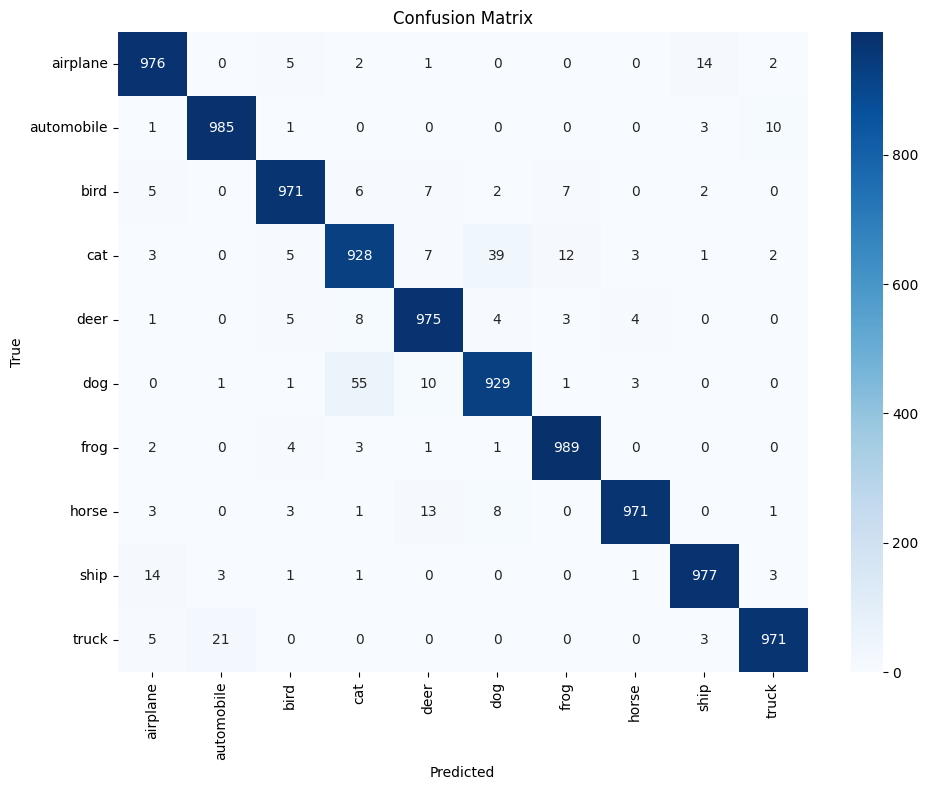

Saved classification report and confusion matrix to ./checkpoints_transfer


<Figure size 640x480 with 0 Axes>

In [ ]:
# Cell 9: Final evaluation — classification report + confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Final test preds"):
        imgs = imgs.to(device)
        outputs = model(imgs)               # model returns logits
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(labels.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=4)
print("Classification report:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Save results
os.makedirs(SAVE_DIR, exist_ok=True)
with open(os.path.join(SAVE_DIR, "classification_report.txt"), "w") as f:
    f.write(report)
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), bbox_inches='tight')
print("Saved classification report and confusion matrix to", SAVE_DIR)


Cell 10 — t-SNE visualization of penultimate features (optional — may take time)

In [ ]:
# Cell 10: t-SNE of penultimate features (sample of dataset)
# WARNING: this is optional and can be slow. Reduce n_samples for speed.
from sklearn.manifold import TSNE

def extract_penultimate_features(net, imgs):
    """
    Extract features before final fc for ResNet-like models.
    Adjust if your model architecture differs.
    Input: imgs - tensor on device
    Output: numpy array [B, feat_dim]
    """
    # Try to find a direct extractor if available
    if hasattr(net, 'encoder'):  # SimCLR or custom
        with torch.no_grad():
            feats = net.encoder(imgs)
        return feats.cpu().numpy()
    # For torchvision ResNet (standard)
    net.eval()
    with torch.no_grad():
        x = net.conv1(imgs)
        x = net.bn1(x)
        x = net.relu(x)
        x = net.maxpool(x)
        x = net.layer1(x)
        x = net.layer2(x)
        x = net.layer3(x)
        x = net.layer4(x)
        x = net.avgpool(x)
        x = torch.flatten(x, 1)
    return x.cpu().numpy()

def tsne_plot_sample(net, dataset, n_samples=1500, perplexity=30):
    loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=NUM_WORKERS)
    imgs_collected = []
    labels_collected = []
    for imgs, labels in loader:
        imgs_collected.append(imgs)
        labels_collected.append(labels)
        if sum([x.shape[0] for x in imgs_collected]) >= n_samples:
            break
    imgs_all = torch.cat(imgs_collected, dim=0)[:n_samples].to(device)
    labels_all = torch.cat(labels_collected, dim=0)[:n_samples].numpy()

    feats = extract_penultimate_features(net, imgs_all)   # [n_samples, feat_dim]
    print("Feature shape:", feats.shape)

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=SEED)
    Z = tsne.fit_transform(feats)

    plt.figure(figsize=(8,8))
    scatter = plt.scatter(Z[:,0], Z[:,1], c=labels_all, cmap='tab10', s=6)
    plt.legend(handles=scatter.legend_elements()[0], labels=test_dataset.classes, bbox_to_anchor=(1.05,1))
    plt.title(f"t-SNE of penultimate features (n={n_samples})")
    plt.tight_layout()
    plt.show()

# Run t-SNE (adjust n_samples to 500-1500 depending on time)
# tsne_plot_sample(model, test_dataset, n_samples=1200, perplexity=30)


Cell 11 — Show sample predictions with confidence (denormalize for display)

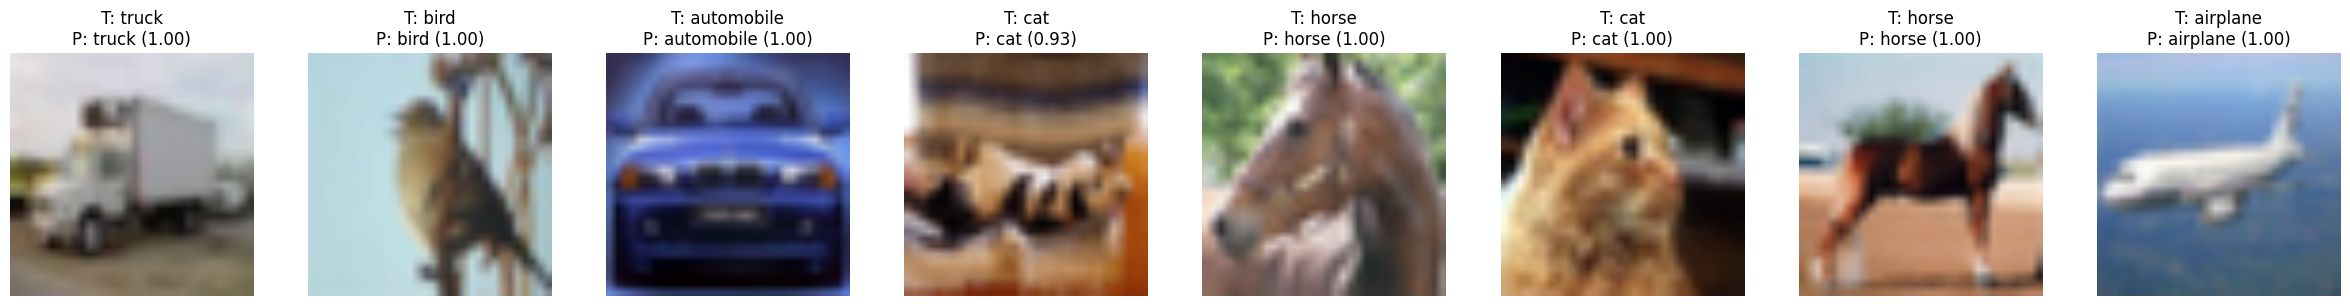

In [ ]:
# Cell 11: Show sample predictions (image, true label, predicted label, confidence)
import numpy as np
import matplotlib.pyplot as plt

# Denormalize helper (ImageNet mean/std by default)
IMAGENET_MEAN = np.array(IMAGENET_MEAN) if 'IMAGENET_MEAN' in globals() else np.array([0.485,0.456,0.406])
IMAGENET_STD  = np.array(IMAGENET_STD)  if 'IMAGENET_STD'  in globals() else np.array([0.229,0.224,0.225])

def denormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

def show_predictions(model, dataset, indices=None, n=8):
    model.eval()
    if indices is None:
        indices = list(range(n))
    fig, axes = plt.subplots(1, len(indices), figsize=(3*len(indices), 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        inp = img.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(inp)
            probs = torch.nn.functional.softmax(out, dim=1)[0]
            pred = int(probs.argmax().cpu().numpy())
            conf = float(probs[pred].cpu().numpy())
        img_show = denormalize(img)
        ax = axes[i] if len(indices)>1 else axes
        ax.imshow(img_show)
        ax.set_title(f"T: {dataset.classes[label]}\nP: {dataset.classes[pred]} ({conf:.2f})")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage: show 8 random samples
import random
inds = random.sample(range(len(test_dataset)), 8)
show_predictions(model, test_dataset, indices=inds)


Cell 12 — Show correct vs incorrect predictions side-by-side

/tmp/ipython-input-3644995758.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(out.argmax(1).cpu().numpy())
/tmp/ipython-input-3644995758.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3644995758.py:31: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


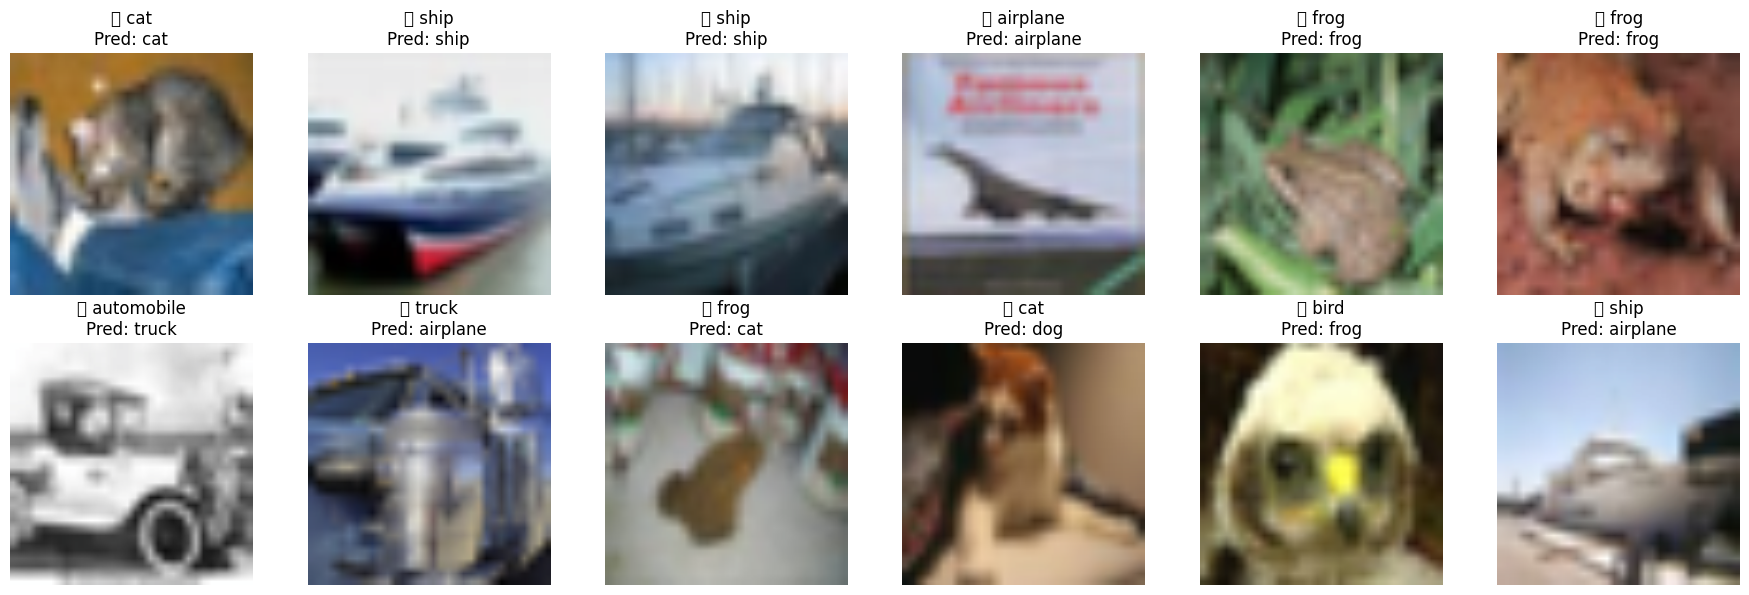

In [ ]:
# Cell 12: Show correct vs wrong predictions (top row: correct, bottom row: wrong)
def show_correct_incorrect(model, dataset, n=6):
    model.eval()
    correct = []
    wrong = []
    with torch.no_grad():
        for i in range(len(dataset)):
            img, label = dataset[i]
            out = model(img.unsqueeze(0).to(device))
            pred = int(out.argmax(1).cpu().numpy())
            if pred == label:
                if len(correct) < n:
                    correct.append((img, label, pred))
            else:
                if len(wrong) < n:
                    wrong.append((img, label, pred))
            if len(correct) >= n and len(wrong) >= n:
                break

    rows = 2
    cols = n
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 6))
    for j, (img, label, pred) in enumerate(correct):
        axes[0,j].imshow(denormalize(img))
        axes[0,j].set_title(f"✅ {dataset.classes[label]}\nPred: {dataset.classes[pred]}")
        axes[0,j].axis('off')
    for j, (img, label, pred) in enumerate(wrong):
        axes[1,j].imshow(denormalize(img))
        axes[1,j].set_title(f"❌ {dataset.classes[label]}\nPred: {dataset.classes[pred]}")
        axes[1,j].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
show_correct_incorrect(model, test_dataset, n=6)


Cell 13 — Optional: Grad-CAM visualization for a few samples

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


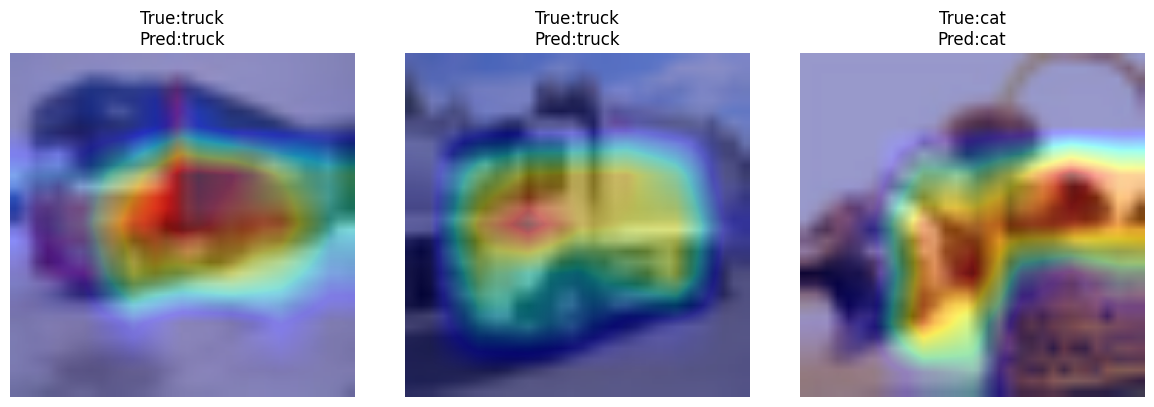

In [ ]:
# Cell 13: Grad-CAM for visual explanation (optional)

import cv2
import random

def gradcam_resnet(model, img_tensor, class_idx=None):
    model.eval()
    features = []
    gradients = []

    def forward_hook(module, inp, out):
        features.append(out.cpu().detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].cpu().detach())

    # ✅ Hook the last convolutional layer for ResNet-50
    target_layer = model.layer4[-1].conv3 if hasattr(model.layer4[-1], 'conv3') else model.layer4[-1].conv2
    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    inp = img_tensor.unsqueeze(0).to(device)
    out = model(inp)
    if class_idx is None:
        class_idx = int(out.argmax(1).cpu().numpy()[0])

    model.zero_grad()
    out[0, class_idx].backward()

    fmap = features[0].squeeze(0).numpy()      # [C, H, W]
    grads = gradients[0].squeeze(0).numpy()    # [C, H, W]

    weights = grads.mean(axis=(1,2))           # [C]
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[1]))
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    fh.remove(); bh.remove()
    return cam, class_idx


def show_gradcam_samples(model, dataset, indices):
    fig, axes = plt.subplots(1, len(indices), figsize=(4*len(indices), 4))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        cam, cls = gradcam_resnet(model, img)
        img_show = denormalize(img)
        ax = axes[i] if len(indices)>1 else axes
        ax.imshow(img_show)
        ax.imshow(cam, cmap='jet', alpha=0.4)
        ax.set_title(f"True:{dataset.classes[label]}\nPred:{dataset.classes[cls]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# ✅ Example usage (actually run this)
inds = random.sample(range(len(test_dataset)), 3)
show_gradcam_samples(model, test_dataset, inds)
